<h1>Setting up the Environment</h1>

<h3>Importing Libraries</h3>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<h3>Color</h3>

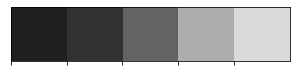

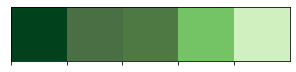

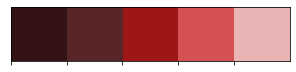

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

<h1>Data Preperation</h1>

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('.\\archive','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('.\\archive','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 165.98it/s]


<h3>Sample Image from each label</h3>

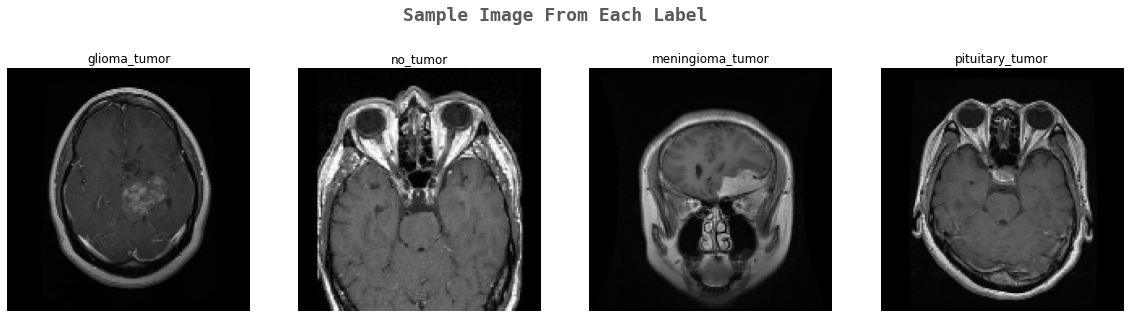

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape


(3264, 150, 150, 3)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

<h1>Transfer Learning<h1>

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

 block2b_expand_bn (BatchNormal  (None, 38, 38, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 38, 38, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 38, 38, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 38, 38, 144)  576        ['block2b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 19, 19, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 19, 19, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_s

                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 10, 10, 480)  0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 10, 10, 112)  53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_p

 block5c_project_bn (BatchNorma  (None, 10, 10, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 10, 10, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 10, 10, 112)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 10, 10, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block6a_e

                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 5, 5, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 5, 5, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 5, 5, 1152)  28800       ['block6c_expand_activation[0][0]
 D)       

                                                                                                  
 block7a_expand_activation (Act  (None, 5, 5, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 5, 5, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 5, 5, 1152)  4608        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_a

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

<h1>Training The Model</h1>

In [15]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8320
Epoch 1: val_accuracy improved from -inf to 0.89456, saving model to effnet.h5
83/83 [==============================] - 276s 3s/step - loss: 0.4650 - accuracy: 0.8320 - val_loss: 0.3149 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9292
Epoch 2: val_accuracy did not improve from 0.89456
83/83 [==============================] - 237s 3s/step - loss: 0.2017 - accuracy: 0.9292 - val_loss: 0.4430 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9644
Epoch 3: val_accuracy did not improve from 0.89456

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [==============================] - 233s 3s/step - loss: 0.0953 - accuracy: 0.9644 - val_loss: 0.4398 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/12
83/83 [=============

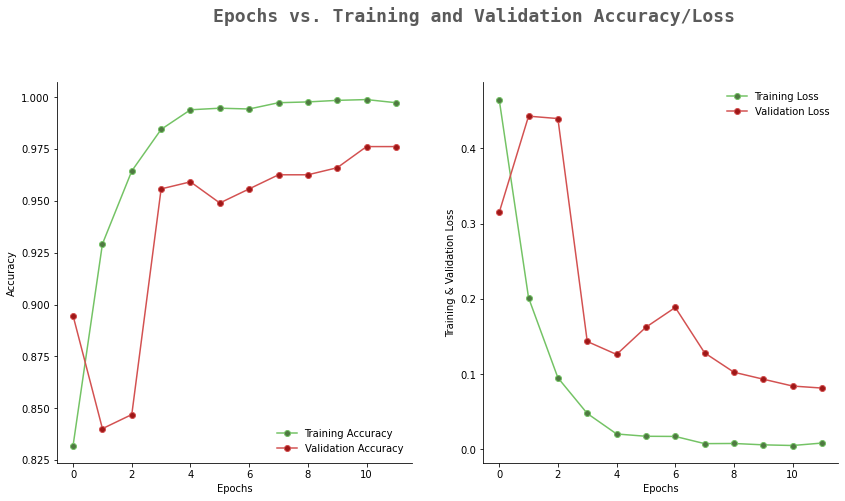

In [21]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

<h1>Prediction</h1>

In [22]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

<h1>Evaluation</h1>

In [23]:
print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        93
           1       0.96      1.00      0.98        51
           2       0.97      0.96      0.96        96
           3       0.99      0.98      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.98      0.97       327
weighted avg       0.97      0.97      0.97       327



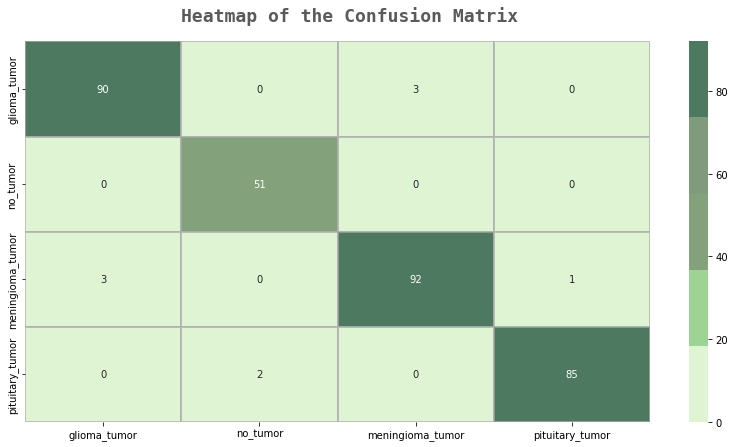

In [24]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

<h1>Bonus Content: Widgets</h1>

In [25]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [26]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [27]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])